In [12]:
import json, re, random
from pathlib import Path
import pandas as pd

path = Path("../data/articles_classified.jsonl")
rows = [json.loads(l) for l in path.read_text(encoding="utf-8").splitlines() if l.strip()]

def clean_text(s: str) -> str:
    if not s:
        return ""
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

random.seed(42)
sample = random.sample(rows, k=min(200, len(rows)))  # 150-200 c'est bien pour annoter 50+

out = []
for i, r in enumerate(sample):
    title = clean_text(r.get("title", ""))
    content = clean_text(r.get("content", ""))

    # éviter title.title
    if content.lower().startswith(title.lower()):
        content = content[len(title):].strip(" .-")

    text = f"{title}. {content}".strip()
    text = text[:1500]

    out.append({
        "id": i,
        "source": r.get("source", ""),
        "url": r.get("url", ""),
        "text": text,
        "label": "",  # <-- tu remplis à la main
        "baseline_pred": r.get("topic_prediction", "")
    })

df = pd.DataFrame(out)
df.to_csv("../data/finetune-dataset.csv", index=False, encoding="utf-8")
print("✅ Saved: ../data/finetune-dataset.csv")
df.head(5)


✅ Saved: ../data/finetune-dataset.csv


,id,source,url,text,label,baseline_pred
0,0,HackerNews,https://www.amusingplanet.com/2026/01/the-anta...,The Antarctic Snow Cruiser.,,Advanced
1,1,HackerNews,https://www.jpmorgan.com/insights/global-resea...,De-dollarization: Is the US dollar losing its ...,,Intermediate
2,2,HackerNews,https://www.unix.dog/~yosh/blog/c-habits-for-m...,Some C habits I employ for the modern day.,,Advanced
3,3,HackerNews,https://airmass.org/,Astrophotography visibility plotting and plann...,,Advanced
4,4,HackerNews,https://blog.jquery.com/2026/01/17/jquery-4-0-0/,jQuery 4.,,Advanced


In [11]:
# pré-remplissage auto
df["label"] = df["baseline_pred"]

df.to_csv("../data/finetune-dataset_prefilled.csv", index=False, encoding="utf-8")
print(" Labels pré-remplis depuis baseline_pred")

 Labels pré-remplis depuis baseline_pred


In [26]:


df = pd.read_csv("../data/finetune-dataset.csv")

df["text_len"] = df["text"].fillna("").str.len()
df["is_show"] = df["text"].str.contains("show hn", case=False, na=False)
df["is_ask"]  = df["text"].str.contains("ask hn", case=False, na=False)
df["is_wiki"] = (df["source"].fillna("") == "Wikipedia")

df["uncertainty_score"] = (
    (df["text_len"] < 120).astype(int) * 3
    + df["is_show"].astype(int) * 2
    + df["is_ask"].astype(int) * 2
    + df["is_wiki"].astype(int) * 2
)

to_review = df.sort_values("uncertainty_score", ascending=False).head(80)
to_review.to_csv("../data/to_review.csv", index=False, encoding="utf-8")

print("✅ Fichier à corriger créé: ../data/to_review.csv")
to_review[["id","source","baseline_pred","text"]].head(10)


✅ Fichier à corriger créé: ../data/to_review.csv


,id,source,baseline_pred,text
24,24,HackerNews,Intermediate,"Show HN: Mastra 1.0, open-source JavaScript ag..."
26,26,HackerNews,Advanced,Ask HN: What did you find out or explore today?.
28,28,HackerNews,Intermediate,Show HN: Sparrow-1 – Audio-native model for hu...
20,20,HackerNews,Intermediate,Show HN: HTTP:COLON – A quick HTTP header/dire...
21,21,HackerNews,Advanced,Show HN: Movieagent.io – An agent for movie re...
14,14,HackerNews,Intermediate,Show HN: Lume 0.2 – Build and Run macOS VMs wi...
15,15,HackerNews,Advanced,Show HN: Xenia – A monospaced font built with ...
10,10,HackerNews,Intermediate,Show HN: Ocrbase – pdf → .md/.json document OC...
36,36,HackerNews,Intermediate,"Show HN: ChunkHound, a local-first tool for un..."
65,65,HackerNews,Intermediate,Show HN: Artificial Ivy in the Browser.


In [27]:
import pandas as pd

df = pd.read_csv("../data/finetune-dataset.csv")

# lignes où label ≠ baseline_pred
diff = df[df["label"] != df["baseline_pred"]]
print("Nb de désaccords :", len(diff))

diff[["text", "label", "baseline_pred"]].head(10)


Nb de désaccords : 190


,text,label,baseline_pred
0,The Antarctic Snow Cruiser.,Intermediate,Advanced
1,De-dollarization: Is the US dollar losing its ...,Advanced,Intermediate
3,Astrophotography visibility plotting and plann...,Intermediate,Advanced
4,jQuery 4.,Beginner,Advanced
5,Radboud University selects Fairphone as standa...,Intermediate,Advanced
6,The Overcomplexity of the Shadcn Radio Button.,Intermediate,Advanced
7,Why Walmart still doesn't support Apple Pay.,Beginner,Intermediate
8,"Google co-founder reveals that ""many"" of the n...",NaN,Beginner
12,Porsche sold more electrified cars in Europe i...,Beginner,Advanced
13,How to be a good conference talk audience memb...,Intermediate,Advanced


In [28]:
import pandas as pd

df = pd.read_csv("../data/finetune-dataset.csv")

# On ne prend que 30 articles pour commencer
subset = df.sample(30, random_state=42)

subset[["text", "baseline_pred"]]


,text,baseline_pred
95,Cataloging Failed VC-Backed Startups and Re-Ev...,Intermediate
15,Show HN: Xenia – A monospaced font built with ...,Advanced
30,Floating-Point Printing and Parsing Can Be Sim...,Intermediate
158,Nanolang: A tiny experimental language designe...,Advanced
128,Machine learning. (ML) is a field of study in ...,Advanced
115,The recurring dream of replacing developers.,Advanced
69,CD Projekt issue DMCA takedown notice against ...,Advanced
170,Unconventional PostgreSQL Optimizations.,Advanced
174,Show HN: An interactive physics simulator with...,Intermediate
45,Show HN: Streaming gigabyte medical images fro...,Advanced


In [24]:
to_annotate = df[df["label"].isna()]
to_annotate[["text", "baseline_pred"]].head(30)



,text,baseline_pred
0,The Antarctic Snow Cruiser.,Advanced
1,De-dollarization: Is the US dollar losing its ...,Intermediate
2,Some C habits I employ for the modern day.,Advanced
3,Astrophotography visibility plotting and plann...,Advanced
4,jQuery 4.,Advanced
5,Radboud University selects Fairphone as standa...,Advanced
6,The Overcomplexity of the Shadcn Radio Button.,Advanced
7,Why Walmart still doesn't support Apple Pay.,Intermediate
8,"Google co-founder reveals that ""many"" of the n...",Beginner
9,Dev-owned testing: Why it fails in practice an...,Advanced


In [29]:
from sklearn.metrics import accuracy_score

df_eval = subset.dropna(subset=["label"])
accuracy_score(df_eval["label"], df_eval["baseline_pred"])


0.6666666666666666

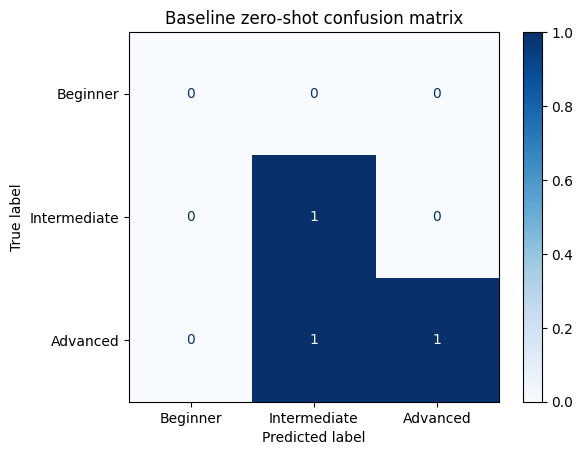

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = ["Beginner", "Intermediate", "Advanced"]

cm = confusion_matrix(
    df_eval["label"],
    df_eval["baseline_pred"],
    labels=labels
)

disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title("Baseline zero-shot confusion matrix")
plt.show()


In [30]:
import pandas as pd

df = pd.read_csv("../data/finetune-dataset.csv")

# prend ceux pas encore annotés
df_na = df[df["label"].isna()]

# sample équilibré par baseline_pred (utile pour varier)
subset = (
    df_na.groupby("baseline_pred", group_keys=False)
         .apply(lambda x: x.sample(min(20, len(x)), random_state=42))
)

subset = subset.sample(min(60, len(subset)), random_state=42)  # total ~60
subset[["id","text","baseline_pred","label"]].head(10)


C:\Users\DELL\AppData\Local\Temp\ipykernel_7344\473410525.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(20, len(x)), random_state=42))


,id,text,baseline_pred,label
95,95,Cataloging Failed VC-Backed Startups and Re-Ev...,Intermediate,NaN
156,156,Giving university exams in the age of chatbots.,Advanced,NaN
45,45,Show HN: Streaming gigabyte medical images fro...,Advanced,NaN
78,78,11% of vibe-coded apps are leaking Supabase keys.,Intermediate,NaN
26,26,Ask HN: What did you find out or explore today?.,Advanced,NaN
109,109,A Brief History of Ralph.,Intermediate,NaN
158,158,Nanolang: A tiny experimental language designe...,Advanced,NaN
141,141,CSS Web Components for marketing sites (2024).,Intermediate,NaN
43,43,x86 prefixes and escape opcodes flowchart.,Intermediate,NaN
110,110,Targeted Bets: An alternative approach to the ...,Advanced,NaN


In [31]:
subset.to_csv("../data/annotate_60.csv", index=False, encoding="utf-8")
print("Saved: ../data/annotate_60.csv")


Saved: ../data/annotate_60.csv
